In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
sns.set_style("darkgrid")

#### Read in the data

In [2]:
dirname = '/Users/austinlasseter/DSI-EC-2/projects/datasets/proj_3/'
data = pd.read_csv(dirname + 'clean_data.csv')

In [3]:
# Create the outcome variable
data['over_under']=(data['comments']>data['comments'].median()).astype(int)
print(data.shape)
data.head()

(5304, 10)


,title,subreddit,comments,minutes,which_sub,AskReddit,big4,others,length,over_under
0,"""@thebigjamesg: what kind of president doesn't...",TrumpCriticizesTrump,205,720,others,0,0,1,160,1
1,"""alright pinchy, my little bucket of badness, ...",lego,122,960,others,0,0,1,113,1
2,"""are you my dad?""",aww,10,120,others,0,0,1,17,0
3,"""behold a pale horse"" book from 1991, by bill ...",CBTS_Stream,4,180,others,0,0,1,149,0
4,"""can i have a 5p bag with that?"". ""sorry, we o...",britishproblems,366,660,others,0,0,1,138,1


#### Train-Test Split

In [4]:
# Split the training data into a further train/test split (remember, we set aside 30% earlier for final testing)
X = data.drop(['comments', 'over_under'], axis=1)
y = data['over_under']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(3712, 8)

In [5]:
X_test.head(3)

,title,subreddit,minutes,which_sub,AskReddit,big4,others,length
530,"baby kulu-ya-ku , by me :3",MonsterHunter,480,others,0,0,1,26
3527,so this guy payed my friend to get my number.....,niceguys,1020,others,0,0,1,61
3165,pretty minging,ScottishPeopleTwitter,300,others,0,0,1,14


## Count Vectorizer on `Title`

In [6]:
# Initialize a standard CountVectorizer and fit the training data.
cvec = CountVectorizer(stop_words='english', max_features=1000)
cvec.fit(X_train['title']);
cvecdata = cvec.transform(X_train['title'])
cvec_title  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names(), 
                          index=X_train.index) # hat tip to Shaver for this last line, it was a life-saver.

In [7]:
# What is the shape of that dataframe?
cvec_title.shape 

(3712, 1000)

In [8]:
# Check out that matrix
cvec_title.head(3)

,000,10,100,12,15,17,18,1983,1985,1991,...,yeah,year,years,yes,yesterday,york,yosemite,young,youtube,zoo
1672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check out the most commonly used words (this is purely exploratory & doesn't affect my model)

In [9]:
# Because we set max_feature=1000, these are the 1000 most commonly used words. About half get 6+ appearances.
common=cvec_title.sum()
print(common.describe())

count    1000.00000
mean       10.06800
std         9.63609
min         4.00000
25%         5.00000
50%         7.00000
75%        11.00000
max       112.00000
dtype: float64


In [10]:
# List the 15 most commonly used words.
common.sort_values(ascending=False).head(15) 

just      112
like       84
new        79
day        74
time       73
people     69
til        65
game       57
today      57
don        54
man        52
old        50
life       50
oc         48
got        47
dtype: int64

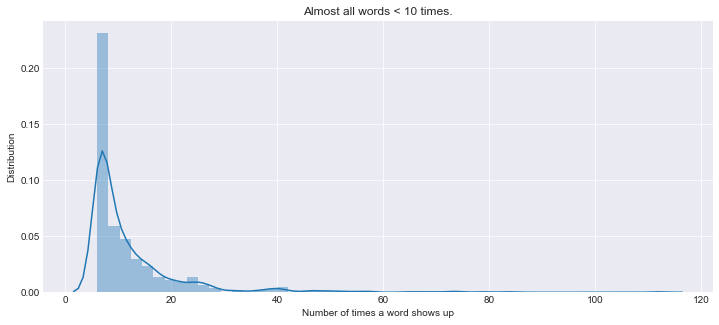

In [11]:
#  Here's the distribution of the common words (>5 times)
fig = plt.figure(figsize=(12,5))
ax=sns.distplot(common[common>5]);
ax.set(ylabel='Distribution', xlabel='Number of times a word shows up', title='Almost all words < 10 times.');

## Combine the vectorized `title` with my other feature columns

#### Transform the training data 

In [12]:
print(X_train.shape)
X_train.head(3)

(3712, 8)


,title,subreddit,minutes,which_sub,AskReddit,big4,others,length
1672,how do you piss of a female archeologist?,Jokes,300,others,0,0,1,41
330,"after mass shooting, school threats in miami s...",news,840,big4,0,1,0,82
3555,someone on my facebook feed found the portal t...,pics,600,big4,0,1,0,73


In [13]:
# Drop the variables I don't need anymore.
X_train_short=X_train.drop(['title', 'subreddit', 'which_sub', 'others'], axis=1)

In [14]:
# Confirm that the two df's I'm about to merge have the same number of rows
print(X_train_short.shape)
print(cvec_title.shape)

(3712, 4)
(3712, 1000)


#### Merge back in the non-text features.

In [15]:
# Merge the datasets back together
X_train_cvec=pd.merge(X_train_short, cvec_title, right_index=True, left_index=True)
print(X_train_cvec.shape) # It's important to confirm that the resulting dataset has the correct # of rows.
# By the way, you also get exactly the same results if you use pd.concat.
X_train_cvec2=pd.concat([X_train_short, cvec_title], axis=1)
print(X_train_cvec2.shape) 
# This step caused me a lot of trouble, until Ben shared the line about setting the index in the Vectorizer.

(3712, 1004)
(3712, 1004)


#### Transform the test data and predict using the trained KNN model

In [16]:
# transform my test data the same way I transformed my train data
vectorizers_test = cvec.transform(X_test['title']) 

In [17]:
# convert the vectorized test data into a pandas dataframe
cvec_test = pd.DataFrame(vectorizers_test.todense(),
                         columns=cvec.get_feature_names(),
                         index=X_test.index) 

#### Merge back in the non-text features.

In [18]:
# Drop the variables I don't need, prior to merging.
X_test_short=X_test.drop(['title', 'subreddit', 'which_sub', 'others'], axis=1)

In [19]:
# Merge.
X_test_cvec=pd.merge(X_test_short, cvec_test, right_index=True, left_index=True)

In [20]:
# I expect these 4 dataframes to have the same number of rows, before and after the merge.
print(X_test.shape)
print(y_test.shape)
print(cvec_test.shape)
print(X_test_cvec.shape)

(1592, 8)
(1592,)
(1592, 1000)
(1592, 1004)


# Model 1. KNN classifier 

#### fit on the training, predict on the testing data

In [21]:
# train the model
neighs = KNeighborsClassifier(n_neighbors=7)
knn_model = neighs.fit(X_train_cvec, y_train)

In [22]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(knn_model, X_train_cvec, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.60479523519693934, 0.0089142829417753946)

In [23]:
# Predict the y values on the testing data.
y_hat = knn_model.predict(X_test_cvec)

#### Score my model

In [24]:
# Set up some empty lists, so we can compare our models at the end
acc=[]
sens=[]
spec=[]
roc=[]

In [25]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(knn_model.score(X_test_cvec, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

60.1130653266
60.1130653266


In [26]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[478 317]
 [318 479]]


In [27]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 60.1003764115
specificity: 60.1257861635


In [28]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)
# However, because we don't have imbalanced classes, it's not absolutely essential.

60.1130812875


# Model 2. Logistic regression

#### fit on the training, predict on the testing data

In [29]:
logit = LogisticRegression()
log_model=logit.fit(X_train_cvec, y_train)

In [30]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(log_model, X_train_cvec, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.63631858099295724, 0.010466018656449369)

In [31]:
# Predict the y values on the testing data.
y_hat = log_model.predict(X_test_cvec)

#### Score my model

In [32]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(accuracy)

61.432160804


In [33]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[521 274]
 [340 457]]


In [34]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 57.3400250941
specificity: 65.534591195


In [35]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

61.4373081445


# Model 3. Random Forest Classifier

#### fit on the training, predict on the testing data

In [36]:
dt = RandomForestClassifier()
tree_model=dt.fit(X_train_cvec, y_train)

In [37]:
# The crossvalidiation score scores our performance on the training data. It's not very good.
scores = cross_val_score(tree_model, X_train_cvec, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.60588282178361308, 0.0097553480445140509)

In [38]:
# Predict the y values on the testing data.
y_hat = tree_model.predict(X_test_cvec)

#### Score my model

In [39]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(accuracy)

58.6683417085


In [40]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[484 311]
 [347 450]]


In [41]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 56.4617314931
specificity: 60.8805031447


In [42]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

58.6711173189


# Compare Models

In [43]:
# Recap those scores for me, please.
models=['KNN', 'Logistic', 'Random Forest']
cols=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC']
print(acc)
print(sens)
print(spec)
print(roc)

[60.113065326633162, 61.4321608040201, 58.668341708542712]
[60.100376411543287, 57.340025094102884, 56.461731493099123]
[60.125786163522015, 65.534591194968556, 60.880503144654085]
[60.113081287532644, 61.43730814453572, 58.671117318876597]


In [44]:
# Show me that in a table:
model_scores=pd.DataFrame(list(map(list, zip(models, acc, sens, spec, roc))), columns=cols)
model_scores

,Model,Accuracy,Sensitivity,Specificity,ROC-AUC
0,KNN,60.113065,60.100376,60.125786,60.113081
1,Logistic,61.432161,57.340025,65.534591,61.437308
2,Random Forest,58.668342,56.461731,60.880503,58.671117


Text(0,0.5,'Score')

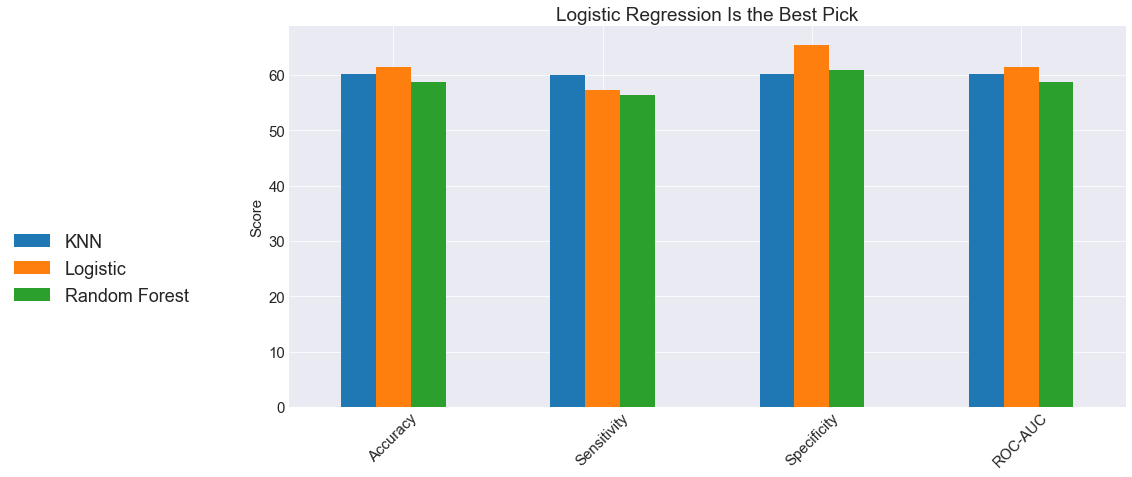

In [47]:
# Make it pretty. 
ax = model_scores.set_index('Model').T.plot(kind='bar', legend=False, fontsize=12, figsize=(15, 7))
ax.legend(loc=1, fontsize=18, bbox_to_anchor=(-0.1, 0.5))
plt.xticks(rotation = 45,  fontsize=15)
plt.title('Logistic Regression Is the Best Pick',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=15)
plt.ylabel('Score', rotation=90,  fontsize=15)  